In [1]:
pip install tf-keras


[notice] A new release of pip available: 22.2.2 -> 25.3
[notice] To update, run: C:\Users\lucio\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import re
import os
import torch
import gc
import spacy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sentence_transformers import SentenceTransformer, InputExample, losses
from datasets import load_dataset, Dataset
from torch.utils.data import DataLoader
from spacy.matcher import PhraseMatcher
import warnings
warnings.filterwarnings('ignore')
import nltk

In [3]:
#Load cleaned text ------
train_df = pd.read_csv("train_JD_resume.csv")
test_df = pd.read_csv("test_JD_resume.csv")

train_df = train_df.astype({"jd": str, "resume": str, "label": str})
test_df = test_df.astype({"jd": str, "resume": str, "label": str})

In [4]:
#Filter out short text ---
train_df = train_df[
    (train_df["jd"].apply(lambda x: len(x.split())) > 10) &
    (train_df["resume"].apply(lambda x: len(x.split())) > 10)
]

test_df = test_df[
    (test_df["jd"].apply(lambda x: len(x.split())) > 10) &
    (test_df["resume"].apply(lambda x: len(x.split())) > 10)
]

In [5]:
# Convert to HuggingFace datasets
train_raw = Dataset.from_pandas(train_df)
test_raw = Dataset.from_pandas(test_df)

In [6]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("sentence-transformers/all-MiniLM-L12-v2")

def encode_batch(batch):
    # batch["jd"] and batch["resume"] are lists of strings
    jd_embs = model.encode(batch["jd"], convert_to_numpy=True)
    resume_embs = model.encode(batch["resume"], convert_to_numpy=True)

    batch["jd_emb"] = jd_embs.tolist()
    batch["resume_emb"] = resume_embs.tolist()
    return batch

train_raw = train_raw.map(encode_batch, batched=True, batch_size=32)
test_raw = test_raw.map(encode_batch, batched=True, batch_size=32)

Map:   0%|          | 0/6218 [00:00<?, ? examples/s]

Map:   0%|          | 0/1754 [00:00<?, ? examples/s]

In [7]:
train_raw.save_to_disk("resume_jd_train_embedded")
test_raw.save_to_disk("resume_jd_test_embedded")

Saving the dataset (0/1 shards):   0%|          | 0/6218 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1754 [00:00<?, ? examples/s]

In [8]:
def text_lengths(texts):
    # simple token count as length feature
    return np.array([len(t.split()) for t in texts], dtype=np.float32)

def build_feature_matrix(ds):
    # embeddings: list[list[float]] -> np.array [N, d]
    jd_emb = np.array(ds["jd_emb"], dtype=np.float32)
    rs_emb = np.array(ds["resume_emb"], dtype=np.float32)

    # 1) cosine similarity
    dot = (jd_emb * rs_emb).sum(axis=1)
    jd_norm = np.linalg.norm(jd_emb, axis=1)
    rs_norm = np.linalg.norm(rs_emb, axis=1)
    cos_sim = dot / (jd_norm * rs_norm + 1e-8)

    # 2) |r - j| stats
    diff = np.abs(jd_emb - rs_emb)
    diff_mean = diff.mean(axis=1)
    diff_max  = diff.max(axis=1)
    diff_std  = diff.std(axis=1)

    # 3) (r ⊙ j) stats
    prod = jd_emb * rs_emb
    prod_max  = prod.max(axis=1)
    prod_min  = prod.min(axis=1)

    # 4) length-based features
    jd_len = text_lengths(ds["jd"])
    rs_len = text_lengths(ds["resume"])
    len_ratio = rs_len / (jd_len + 1e-8)

    # final feature matrix [N, 10]
    X = np.stack(
        [
            cos_sim,
            diff_mean, diff_max, diff_std,
            prod_max, prod_min,
            len_ratio,
        ],
        axis=1,
    )
    return X

In [9]:
label_map = {
    "No Fit": 0,
    "Potential Fit": 1,
    "Good Fit": 2,
}

def labels_to_array(ds):
    return np.array([label_map[y] for y in ds["label"]], dtype=np.int64)


In [10]:
X_full = build_feature_matrix(train_raw)
y_full = labels_to_array(train_raw)

In [11]:
feature_names = [
    "cos_sim",
    "diff_mean", "diff_max", "diff_std"
    , "prod_max", "prod_min",
    "len_ratio",
]

df_preview = pd.DataFrame(X_full[:10], columns=feature_names)
df_preview["label"] = y_full[:10]
print(df_preview)

    cos_sim  diff_mean  diff_max  diff_std  prod_max  prod_min  len_ratio  \
0  0.484620   0.041703  0.160746  0.030743  0.014136 -0.005144   1.360976   
1  0.229583   0.050644  0.221771  0.038049  0.020940 -0.008998   0.862069   
2  0.417460   0.044264  0.162852  0.032784  0.013720 -0.005658   1.919463   
3  0.236039   0.049898  0.210160  0.038589  0.017979 -0.008838   2.917647   
4  0.255572   0.049406  0.203405  0.037898  0.018798 -0.010216   1.343629   
5  0.332174   0.046822  0.188530  0.035860  0.015038 -0.008414   1.228916   
6  0.523059   0.039521  0.149055  0.030367  0.023966 -0.005426   2.706522   
7  0.361487   0.045368  0.203556  0.035599  0.014853 -0.005432   2.262712   
8  0.446597   0.043417  0.159366  0.031579  0.021746 -0.006314   1.304569   
9  0.287867   0.047752  0.204146  0.037799  0.021208 -0.010411   0.892256   

   label  
0      0  
1      0  
2      0  
3      0  
4      0  
5      0  
6      0  
7      0  
8      0  
9      0  


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full,
    test_size=0.2,
    stratify=y_full,
    random_state=42,
)

In [13]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

# Train classifier
clf = LogisticRegression(
    solver="lbfgs",
    multi_class="multinomial",
    class_weight="balanced",
    max_iter=2000
)

clf.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,2000
,multi_class,'multinomial'


In [14]:
val_pred = clf.predict(X_val_scaled)

print(classification_report(
    y_val, val_pred,
    target_names=["no fit", "potential fit", "good fit"]
))

print(confusion_matrix(y_val, val_pred))

               precision    recall  f1-score   support

       no fit       0.61      0.49      0.54       628
potential fit       0.33      0.25      0.28       308
     good fit       0.35      0.57      0.43       308

     accuracy                           0.45      1244
    macro avg       0.43      0.44      0.42      1244
 weighted avg       0.47      0.45      0.45      1244

[[309 111 208]
 [112  76 120]
 [ 88  45 175]]


In [15]:
# Map 3 classes → binary: 0 = no fit, 1 = fit (potential or good)
binary_label_map = {
    "No Fit": 0,
    "Potential Fit": 1,
    "Good Fit": 1,
}

def labels_to_binary(ds):
    return np.array([binary_label_map[y] for y in ds["label"]], dtype=np.int64)

# Reuse features
X_full = build_feature_matrix(train_raw)
y_full_bin = labels_to_binary(train_raw)

print("X_full shape:", X_full.shape)
print("y_full_bin shape:", y_full_bin.shape)
print("Binary label counts:", np.bincount(y_full_bin))

X_full shape: (6218, 7)
y_full_bin shape: (6218,)
Binary label counts: [3137 3081]


In [16]:
X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full_bin,
    test_size=0.2,
    stratify=y_full_bin,
    random_state=42,
)

In [17]:
scaler_bin = StandardScaler()
X_train_scaled = scaler_bin.fit_transform(X_train)
X_val_scaled   = scaler_bin.transform(X_val)

In [18]:
clf_bin = LogisticRegression(
    solver="lbfgs",
    class_weight="balanced",
    max_iter=2000,
)

clf_bin.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,2000
,multi_class,'deprecated'


In [19]:
val_pred = clf_bin.predict(X_val_scaled)

print(classification_report(
    y_val, val_pred,
    target_names=["no fit", "fit"]
))

print("Confusion matrix:")
print(confusion_matrix(y_val, val_pred))

              precision    recall  f1-score   support

      no fit       0.59      0.61      0.60       628
         fit       0.59      0.57      0.58       616

    accuracy                           0.59      1244
   macro avg       0.59      0.59      0.59      1244
weighted avg       0.59      0.59      0.59      1244

Confusion matrix:
[[382 246]
 [263 353]]


In [20]:
def build_big_features(ds):
    r = np.array(ds["resume_emb"], dtype=np.float32)  # [N, 384]
    j = np.array(ds["jd_emb"], dtype=np.float32)      # [N, 384]

    diff = np.abs(r - j)
    prod = r * j

    X = np.concatenate([r, j, diff, prod], axis=1)    # [N, 1536]
    return X

X_full_big = build_big_features(train_raw)
y_full_bin = labels_to_binary(train_raw)  # same function from earlier

print("X_full_big shape:", X_full_big.shape)
print("Binary labels:", np.bincount(y_full_bin))

X_full_big shape: (6218, 1536)
Binary labels: [3137 3081]


In [21]:
X_train, X_val, y_train, y_val = train_test_split(
    X_full_big, y_full_bin,
    test_size=0.2,
    stratify=y_full_bin,
    random_state=42,
)

In [22]:
scaler_big = StandardScaler()
X_train_scaled = scaler_big.fit_transform(X_train)
X_val_scaled   = scaler_big.transform(X_val)

clf_big = LogisticRegression(
    solver="lbfgs",
    class_weight="balanced",
    max_iter=2000,
)

clf_big.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,2000
,multi_class,'deprecated'


In [23]:
val_pred = clf_big.predict(X_val_scaled)

print(classification_report(
    y_val, val_pred,
    target_names=["no fit", "fit"]
))

print("Confusion Matrix:")
print(confusion_matrix(y_val, val_pred))

              precision    recall  f1-score   support

      no fit       0.70      0.67      0.68       628
         fit       0.68      0.71      0.69       616

    accuracy                           0.69      1244
   macro avg       0.69      0.69      0.69      1244
weighted avg       0.69      0.69      0.69      1244

Confusion Matrix:
[[419 209]
 [178 438]]


In [24]:
binary_label_map = {
    "No Fit": 0,
    "Potential Fit": 1,
    "Good Fit": 1,
}

def labels_to_binary(ds):
    return np.array([binary_label_map[y] for y in ds["label"]], dtype=np.int64)

In [25]:
y_full_bin = labels_to_binary(train_raw)
N = len(train_raw)
indices = np.arange(N)

train_idx, val_idx = train_test_split(
    indices,
    test_size=0.2,
    stratify=y_full_bin,
    random_state=42,
)

train_ds = train_raw.select(train_idx)
val_ds   = train_raw.select(val_idx)

print("Train size:", len(train_ds))
print("Val size:", len(val_ds))
print("Label counts (train):", np.bincount(labels_to_binary(train_ds)))
print("Label counts (val):",   np.bincount(labels_to_binary(val_ds)))


Train size: 4974
Val size: 1244
Label counts (train): [2509 2465]
Label counts (val): [628 616]


In [26]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [27]:
# Load base SentenceTransformer (same as before)
bi_model = SentenceTransformer("sentence-transformers/all-MiniLM-L12-v2")

# Build InputExamples for training
train_examples = []
train_labels_bin = labels_to_binary(train_ds)

for jd, resume, y in zip(train_ds["jd"], train_ds["resume"], train_labels_bin):
    # label must be float for CosineSimilarityLoss (0.0 or 1.0)
    train_examples.append(
        InputExample(texts=[jd, resume], label=float(y))
    )

print("Num training pairs:", len(train_examples))

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=8)
train_loss = losses.CosineSimilarityLoss(bi_model)

# Fine-tune (start simple: 1–2 epochs)
bi_model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=2,
    warmup_steps=int(0.1 * len(train_dataloader)),
    show_progress_bar=True,
)

Num training pairs: 4974


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
500,0.197700
1000,0.151600


In [28]:
jd_emb_train_ft     = bi_model.encode(train_ds["jd"],     convert_to_numpy=True, batch_size=32)
resume_emb_train_ft = bi_model.encode(train_ds["resume"], convert_to_numpy=True, batch_size=32)

jd_emb_val_ft     = bi_model.encode(val_ds["jd"],     convert_to_numpy=True, batch_size=32)
resume_emb_val_ft = bi_model.encode(val_ds["resume"], convert_to_numpy=True, batch_size=32)

In [29]:
def build_big_features_from_emb(resume_emb, jd_emb):
    r = resume_emb.astype(np.float32)
    j = jd_emb.astype(np.float32)
    diff = np.abs(r - j)
    prod = r * j
    return np.concatenate([r, j, diff, prod], axis=1)

X_train_big_ft = build_big_features_from_emb(resume_emb_train_ft, jd_emb_train_ft)
X_val_big_ft   = build_big_features_from_emb(resume_emb_val_ft,   jd_emb_val_ft)

y_train_bin = labels_to_binary(train_ds)
y_val_bin   = labels_to_binary(val_ds)


In [30]:
scaler_ft = StandardScaler()
X_train_scaled_ft = scaler_ft.fit_transform(X_train_big_ft)
X_val_scaled_ft   = scaler_ft.transform(X_val_big_ft)

clf_ft = LogisticRegression(
    solver="lbfgs",
    class_weight="balanced",
    max_iter=2000,
)

clf_ft.fit(X_train_scaled_ft, y_train_bin)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,2000
,multi_class,'deprecated'


In [31]:
val_pred_ft = clf_ft.predict(X_val_scaled_ft)

print(classification_report(
    y_val_bin, val_pred_ft,
    target_names=["no fit", "fit"]
))

print(confusion_matrix(y_val_bin, val_pred_ft))

              precision    recall  f1-score   support

      no fit       0.82      0.84      0.83       628
         fit       0.83      0.81      0.82       616

    accuracy                           0.83      1244
   macro avg       0.83      0.83      0.83      1244
weighted avg       0.83      0.83      0.83      1244

[[528 100]
 [117 499]]


In [32]:
import spacy
import re

nlp = spacy.load("en_core_web_lg")

In [33]:
PHRASE_TRIGGERS = [
    "experience in", "experience with", "knowledge of",
    "familiar with", "familiarity with",
    "expertise in", "proficient in", "ability to",
    "capacity to", "competent in"
]

YEARS_PATTERN = re.compile(r"(\d+)\+?\s+years?")

In [34]:
def extract_skills(text):
    """Extract skills using spaCy noun chunks and regex patterns"""
    doc = nlp(text)
    skills = set()

    # 1) noun chunks 
    for chunk in doc.noun_chunks:
        c = chunk.text.strip().lower()
        if 3 <= len(c) <= 50:
            skills.add(c)

    # 2) regex-based patterns
    lower = text.lower()
    for trig in PHRASE_TRIGGERS:
        if trig in lower:
            pattern = rf"{trig}\s+([\w\s\-]+)"
            matches = re.findall(pattern, lower)
            for m in matches:
                skill = m.strip()
                if 3 < len(skill) < 60:
                    skills.add(skill)

    return skills

In [35]:
def extract_years(text):
    """Extract years of experience"""
    matches = YEARS_PATTERN.findall(text.lower())
    if matches:
        return max(int(y) for y in matches)
    return 0

In [36]:
def extract_education(text):
    """Extract education level"""
    t = text.lower()

    if "phd" in t or "doctorate" in t:
        return 3
    if "master" in t or "m.sc" in t or "msc" in t:
        return 2
    if "bachelor" in t or "b.sc" in t or "bsc" in t:
        return 1
    return 0

In [37]:
def extract_meaningful_sentences(text):
    """Extract meaningful sentences for similarity comparison"""
    doc = nlp(text)
    out = []

    for sent in doc.sents:
        s = sent.text.strip()
        if len(s.split()) < 4:
            continue

        lower = s.lower()

        # skip headings
        if lower.endswith(":"):
            continue
        if lower.startswith(("responsibilities", "skills", "requirements", "duties")):
            continue

        # trigger words that often signal meaning
        if any(word in lower for word in [
            "experience", "knowledge", "ability", "responsible",
            "required", "preferred", "understanding",
            "manage", "develop", "analyze", "coordinate",
        ]):
            out.append(s)

    return out

In [38]:
def extract_advanced_semantic_features(jd, resume):
    """
    Extract advanced semantic features including:
    - Skills overlap
    - Years of experience matching
    - Education level matching
    - Sentence similarity
    """
    # Skills extraction
    jd_skills = extract_skills(jd)
    rs_skills = extract_skills(resume)
    
    skill_overlap = len(jd_skills & rs_skills)
    missing_skills = len(jd_skills - rs_skills)
    skill_jaccard = skill_overlap / max(1, len(jd_skills | rs_skills))
    
    # Experience extraction
    exp_jd = extract_years(jd)
    exp_rs = extract_years(resume)
    exp_gap = exp_rs - exp_jd
    exp_match = int(exp_rs >= exp_jd)
    
    # Education extraction
    edu_jd = extract_education(jd)
    edu_rs = extract_education(resume)
    edu_match = int(edu_rs >= edu_jd)
    
    # Sentence similarity
    jd_sents = extract_meaningful_sentences(jd)
    rs_sents = extract_meaningful_sentences(resume)
    
    if jd_sents and rs_sents:
        jd_vec = bi_model.encode(jd_sents, convert_to_numpy=True)
        rs_vec = bi_model.encode(rs_sents, convert_to_numpy=True)
        # Mean similarity across all sentence pairs
        from sklearn.metrics.pairwise import cosine_similarity
        sim_matrix = cosine_similarity(jd_vec, rs_vec)
        sent_sim = sim_matrix.max()
        sent_sim_mean = sim_matrix.mean()
    else:
        sent_sim = 0.0
        sent_sim_mean = 0.0
    
    return np.array([
        # Skill features
        skill_overlap, missing_skills, skill_jaccard,
        # Experience features
        exp_jd, exp_rs, exp_gap, exp_match,
        # Education features
        edu_jd, edu_rs, edu_match,
        # Similarity features
        sent_sim, sent_sim_mean,
    ], dtype=np.float32)

In [39]:
def extract_basic_semantic_features(jd, resume):
    #Extract basic semantic features
    jd_doc = nlp(jd)
    rs_doc = nlp(resume)
    
    # nouns / verbs
    jd_nouns = {t.lemma_.lower() for t in jd_doc if t.pos_=="NOUN" and t.lemma_.lower() not in ENGLISH_STOP_WORDS}
    jd_verbs = {t.lemma_.lower() for t in jd_doc if t.pos_=="VERB"}
    rs_nouns = {t.lemma_.lower() for t in rs_doc if t.pos_=="NOUN" and t.lemma_.lower() not in ENGLISH_STOP_WORDS}
    rs_verbs = {t.lemma_.lower() for t in rs_doc if t.pos_=="VERB"}
    
    # sentence embeddings similarity
    sim = bi_model.encode([jd, resume], convert_to_numpy=True)
    cos_sim = np.dot(sim[0], sim[1]) / (np.linalg.norm(sim[0]) * np.linalg.norm(sim[1]) + 1e-8)
    
    # overlap scores
    noun_overlap = len(jd_nouns & rs_nouns)
    verb_overlap = len(jd_verbs & rs_verbs)
    
    # lengths
    jd_len_words = len(jd.split())
    rs_len_words = len(resume.split())
    jd_len_sents = len(list(jd_doc.sents))
    rs_len_sents = len(list(rs_doc.sents))
    
    # skill keywords
    SKILL_KEYWORDS = [
        "skills", "skill", "qualifications", "qualification", "requirements",
        "requirement", "prerequisites", "criteria", "capabilities", "capability",
        "eligibility", "background", "credentials", "certifications", "licenses",
        "licences", "ability", "abilities", "competency", "competencies",
        "capable", "capacity", "aptitude", "proficiency", "proficient",
        "self-motivated", "independent", "collaborative", "teamwork",
        "communication", "interpersonal", "organizational", "analytical",
        "problem-solving", "critical thinking", "attention to detail",
        "adaptability", "initiative", "leadership", "time management",
        "multitasking", "responsibilities", "responsibility", "duties",
        "duty", "tasks", "role", "roles", "expectations", "objective",
        "objectives", "job functions", "position summary", "key skills",
        "key qualifications", "essential functions", "desired skills",
        "core skills", "technical skills", "soft skills", "hard skills",
        "education", "educational background", "degree", "certification"
    ]
    
    jd_skills = {t.lemma_.lower() for t in jd_doc if t.lemma_.lower() in SKILL_KEYWORDS}
    rs_skills = {t.lemma_.lower() for t in rs_doc if t.lemma_.lower() in SKILL_KEYWORDS}
    
    missing_skills_basic = len(jd_skills - rs_skills)
    skill_overlap_basic = len(jd_skills & rs_skills)
    
    # Jaccard similarity
    jd_tokens = {t.lemma_.lower() for t in jd_doc if t.is_alpha}
    rs_tokens = {t.lemma_.lower() for t in rs_doc if t.is_alpha}
    jaccard = len(jd_tokens & rs_tokens) / (len(jd_tokens | rs_tokens) + 1e-8)
    
    return np.array([
        # resume features
        len(rs_skills), len(rs_nouns), len(rs_verbs), rs_len_words, rs_len_sents,
        # JD features
        len(jd_skills), len(jd_nouns), len(jd_verbs), jd_len_words, jd_len_sents,
        # Overlap
        skill_overlap_basic, noun_overlap, verb_overlap, missing_skills_basic,
        # Similarity
        cos_sim, jaccard,
    ], dtype=np.float32)

In [40]:
def extract_combined_semantic_features(jd, resume):
    """Combine both basic and advanced semantic features"""
    basic_features = extract_basic_semantic_features(jd, resume)
    advanced_features = extract_advanced_semantic_features(jd, resume)
    return np.concatenate([basic_features, advanced_features])

In [41]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def build_combined_semantic_matrix(dataset, progress=True):
    rows = []
    n_samples = len(dataset["jd"])
    
    if progress:
        from tqdm import tqdm
        iterator = tqdm(zip(dataset["jd"], dataset["resume"]), total=n_samples, desc="Extracting features")
    else:
        iterator = zip(dataset["jd"], dataset["resume"])
    
    for jd, resume in iterator:
        rows.append(extract_combined_semantic_features(jd, resume))
    
    return np.vstack(rows)

semantic_combined_train = build_combined_semantic_matrix(train_ds)
semantic_combined_val = build_combined_semantic_matrix(val_ds)

Extracting features: 100%|█████████████████████████████████████████████████████████| 1244/1244 [09:27<00:00,  2.19it/s]


In [42]:
semantic_scaler = StandardScaler()
semantic_combined_train_scaled = semantic_scaler.fit_transform(semantic_combined_train)
semantic_combined_val_scaled = semantic_scaler.transform(semantic_combined_val)

# Combine with existing embedding features
X_train_combined = np.hstack([X_train_scaled_ft, semantic_combined_train_scaled])
X_val_combined = np.hstack([X_val_scaled_ft, semantic_combined_val_scaled])

In [43]:
clf_combined_lr = LogisticRegression(
    solver="lbfgs",
    class_weight="balanced",
    max_iter=2000,
)
clf_combined_lr.fit(X_train_combined, y_train_bin)

val_pred_combined_lr = clf_combined_lr.predict(X_val_combined)


print("\nLogistic Regression with Combined Features:")
print(classification_report(
    y_val_bin, val_pred_combined_lr,
    target_names=["no fit", "fit"]
))


Logistic Regression with Combined Features:
              precision    recall  f1-score   support

      no fit       0.82      0.85      0.83       628
         fit       0.84      0.82      0.83       616

    accuracy                           0.83      1244
   macro avg       0.83      0.83      0.83      1244
weighted avg       0.83      0.83      0.83      1244



In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif


X = semantic_combined_train_scaled          
labels = y_train_bin          


adv_cols = [
    "skill_overlap", "missing_skills", "skill_jaccard",
    "exp_jd", "exp_rs", "exp_gap", "exp_match",
    "edu_jd", "edu_rs", "edu_match",
    "sent_sim", "sent_sim_mean"
]

basic_cols = [
    "rs_skill_count", "rs_nouns", "rs_verbs", "rs_len_words", "rs_len_sents",
    "jd_skill_count", "jd_nouns", "jd_verbs", "jd_len_words", "jd_len_sents",
    "skill_overlap_basic", "noun_overlap", "verb_overlap", "missing_skills_basic",
    "cos_sim", "jaccard"
]

columns = adv_cols + basic_cols

df = pd.DataFrame(X, columns=columns)
df["label"] = labels




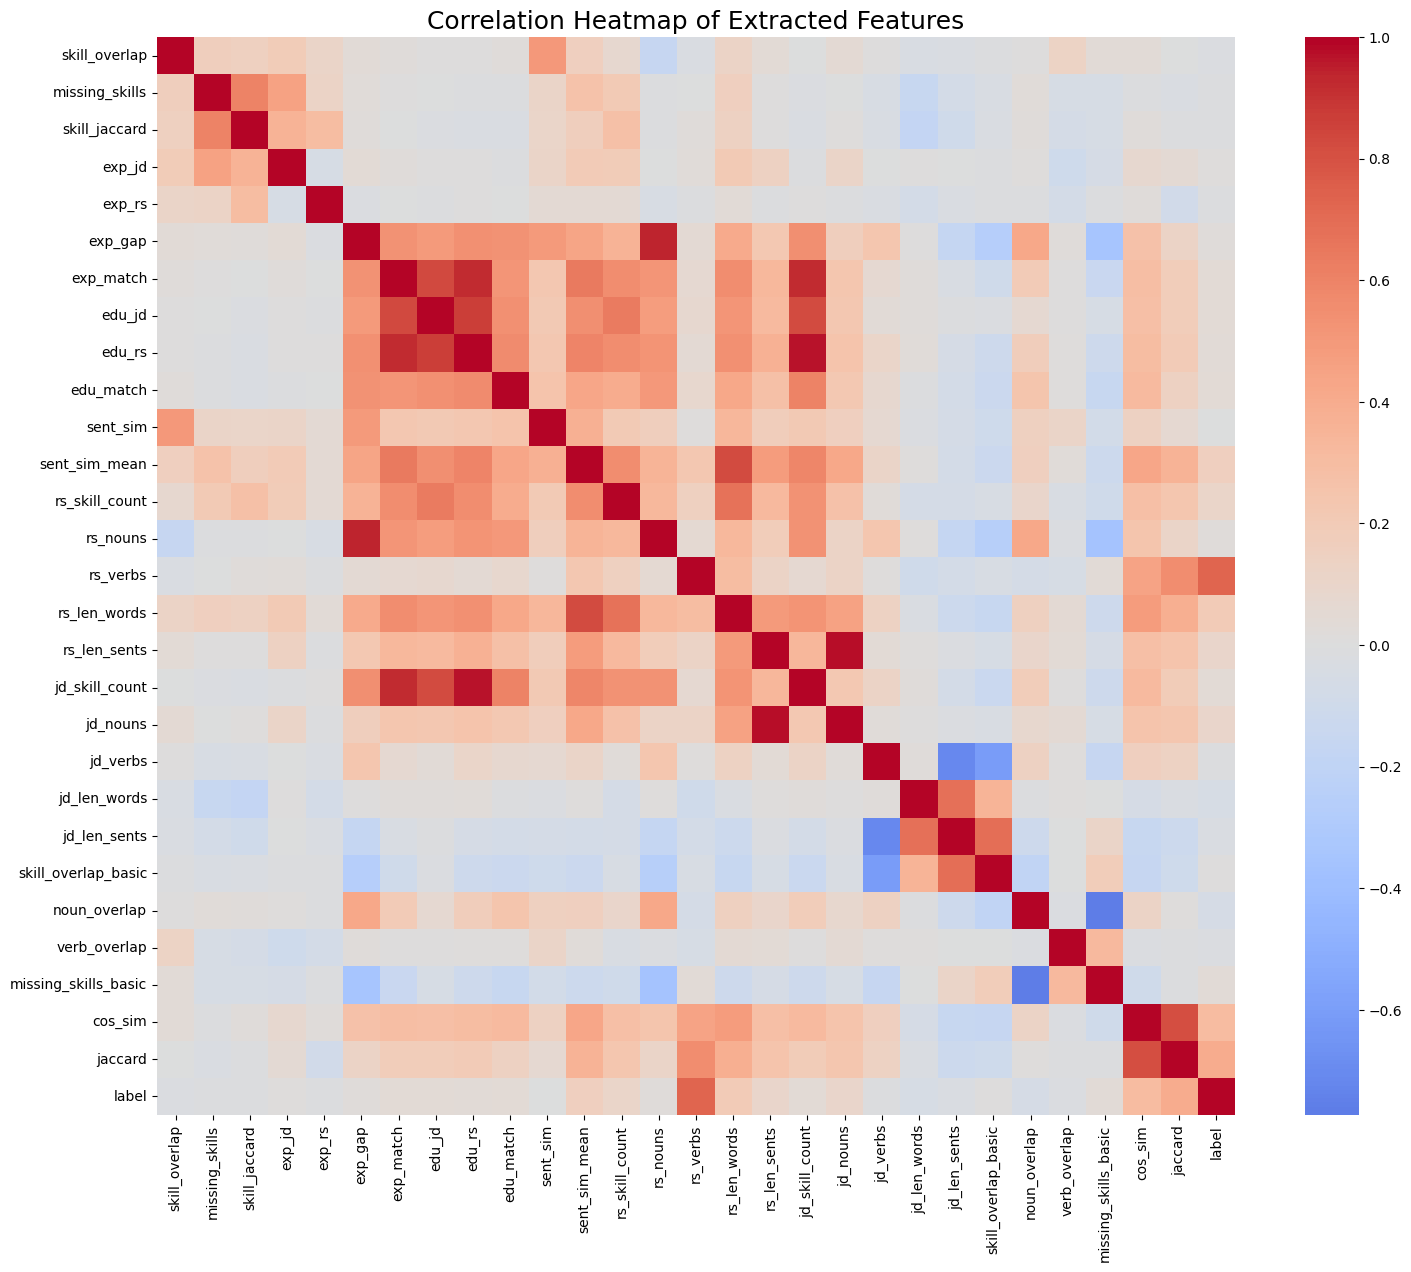

In [46]:
plt.figure(figsize=(18, 14))
corr = df.corr()
sns.heatmap(corr, cmap="coolwarm", center=0, square=True)
plt.title("Correlation Heatmap of Extracted Features", fontsize=18)
plt.show()



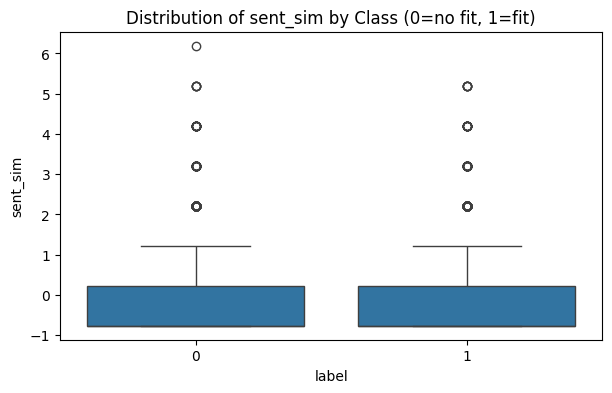

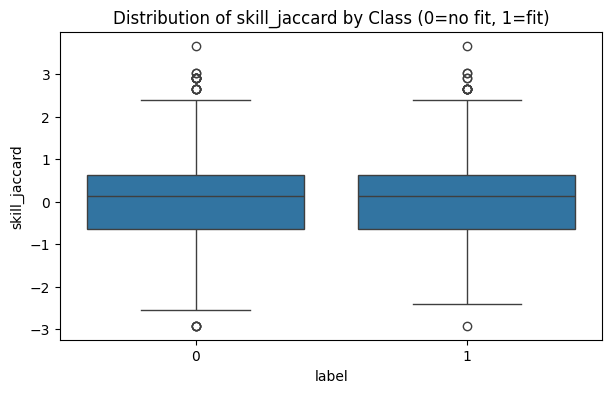

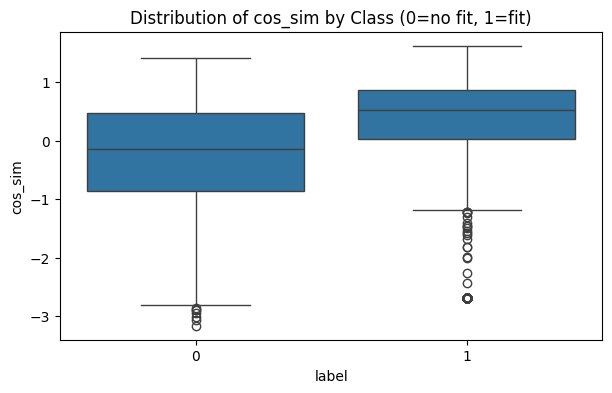

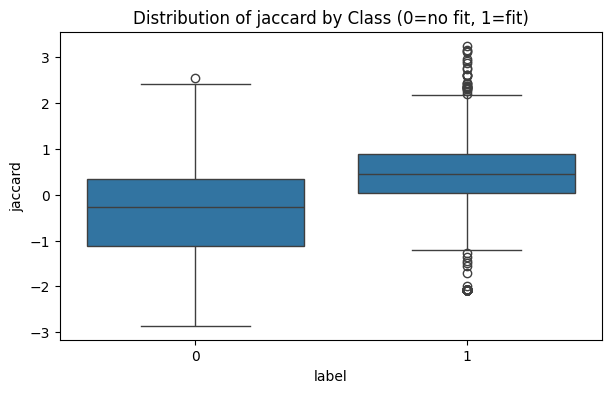

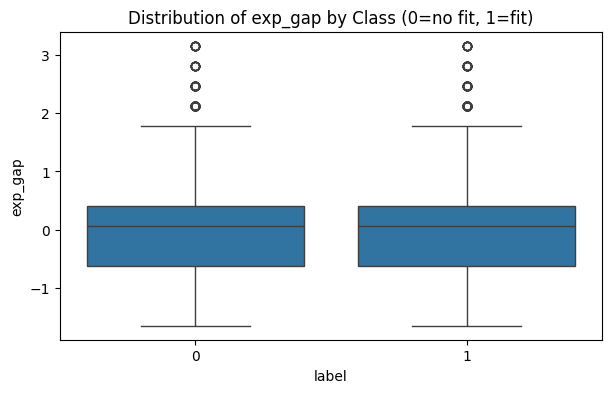

In [49]:
top_features = ["sent_sim", "skill_jaccard", "cos_sim", "jaccard", "exp_gap"]

for feat in top_features:
    plt.figure(figsize=(7, 4))
    sns.boxplot(data=df, x="label", y=feat)
    plt.title(f"Distribution of {feat} by Class (0=no fit, 1=fit)")
    plt.show()





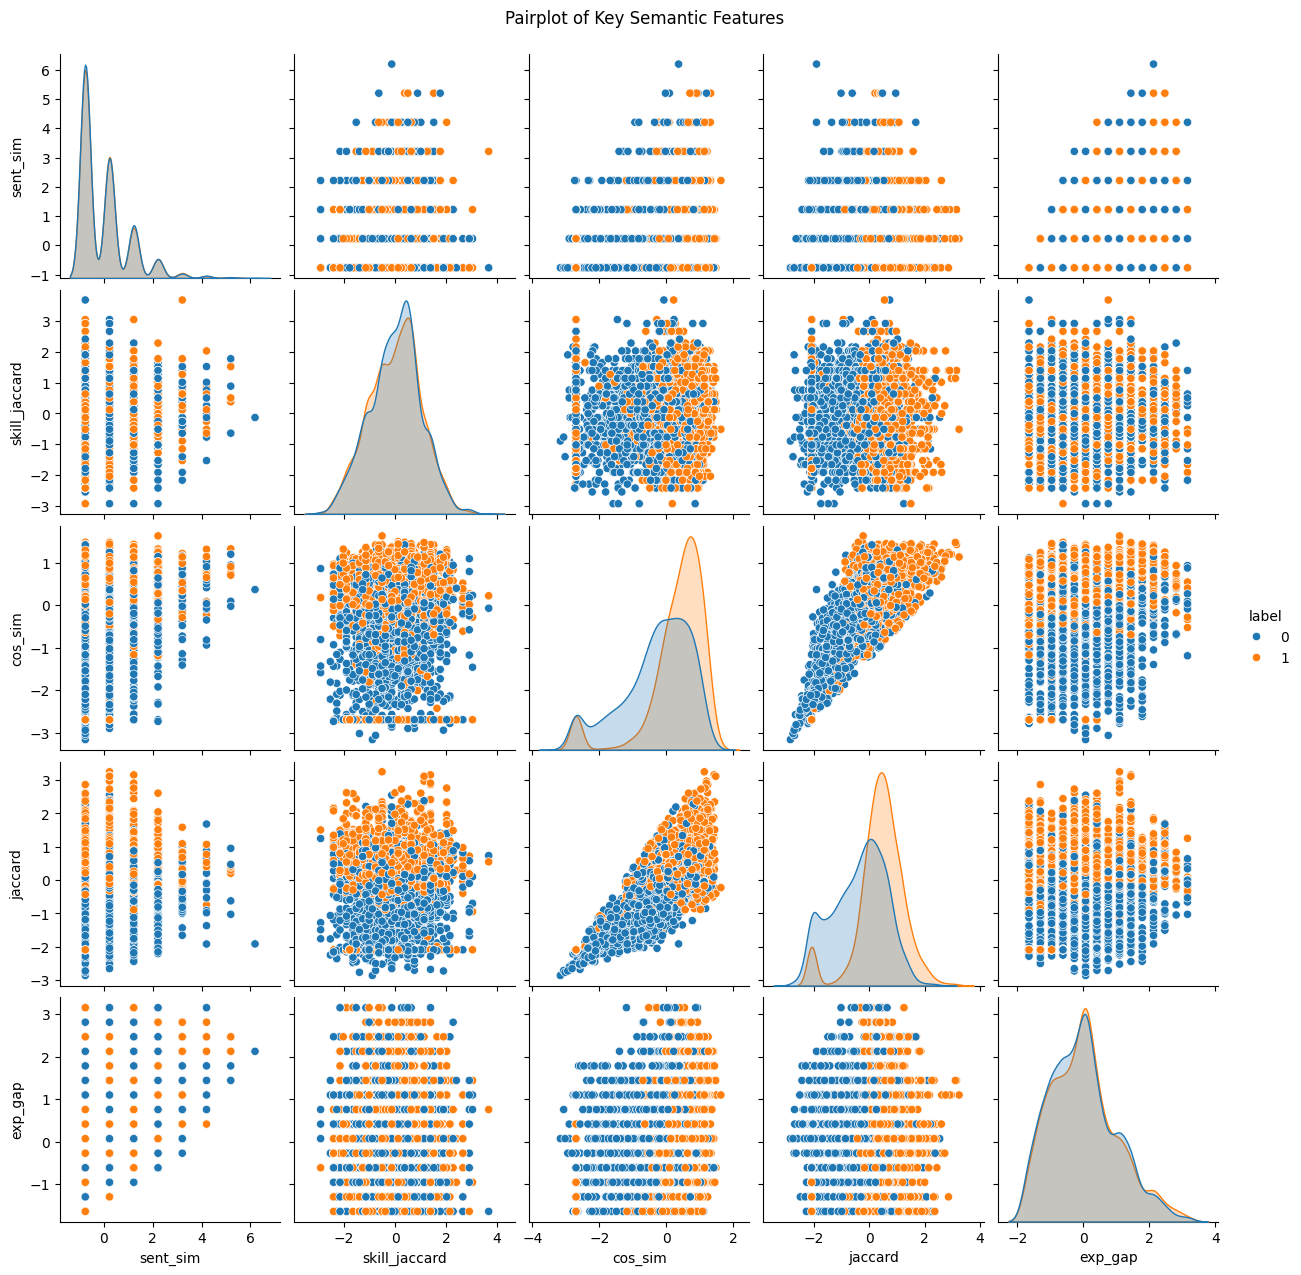

In [50]:
sns.pairplot(df[top_features + ["label"]], hue="label", diag_kind="kde")
plt.suptitle("Pairplot of Key Semantic Features", y=1.02)
plt.show()

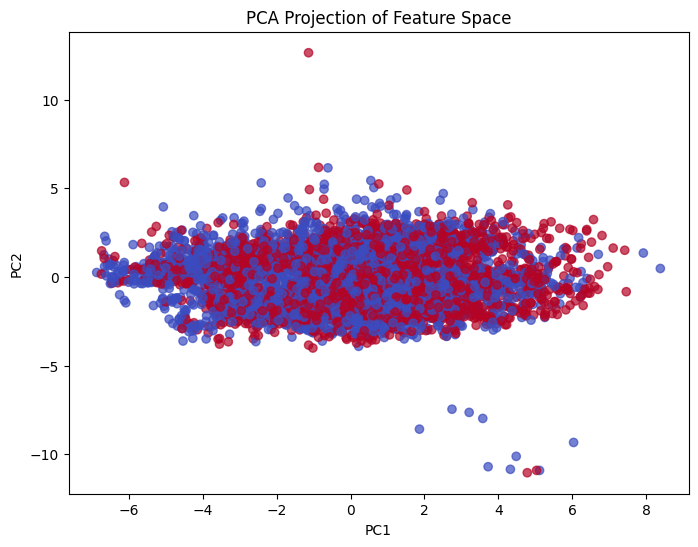

In [51]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap="coolwarm", alpha=0.7)
plt.title("PCA Projection of Feature Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [62]:
from sklearn.neural_network import MLPClassifier

clf_mlp = MLPClassifier(
    hidden_layer_sizes=(512, 256),
    activation="relu",
    solver="adam",
    alpha=1e-4,
    batch_size=64,
    max_iter=30,
    random_state=42
)
clf_mlp.fit(X_train_combined, y_train_bin)

val_pred_mlp = clf_mlp.predict(X_val_combined)
print("\nMLP Classifier with Combined Features:")
print(classification_report(
    y_val_bin, val_pred_mlp,
    target_names=["no fit", "fit"]
))


MLP Classifier with Combined Features:
              precision    recall  f1-score   support

      no fit       0.89      0.84      0.87       628
         fit       0.85      0.89      0.87       616

    accuracy                           0.87      1244
   macro avg       0.87      0.87      0.87      1244
weighted avg       0.87      0.87      0.87      1244



In [53]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(
    n_estimators=100,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
clf_rf.fit(X_train_combined, y_train_bin)

val_pred_rf = clf_rf.predict(X_val_combined)

print(classification_report(
    y_val_bin, val_pred_rf,
    target_names=["no fit", "fit"]
))


              precision    recall  f1-score   support

      no fit       0.82      0.85      0.84       628
         fit       0.84      0.81      0.83       616

    accuracy                           0.83      1244
   macro avg       0.83      0.83      0.83      1244
weighted avg       0.83      0.83      0.83      1244



In [54]:
from xgboost import XGBClassifier

# XGBoost
xgb = XGBClassifier(
    scale_pos_weight=len(y_train_bin[y_train_bin==0])/len(y_train_bin[y_train_bin==1]),
    random_state=42,
    n_jobs=-1
)
# Fit the model
xgb.fit(X_train_combined, y_train_bin)

# Make predictions on validation set
val_pred_xgb = xgb.predict(X_val_combined)

# Print classification report
print("XGBoost Classification Report:")
print(classification_report(
    y_val_bin, val_pred_xgb,
    target_names=["no fit", "fit"]
))

XGBoost Classification Report:
              precision    recall  f1-score   support

      no fit       0.84      0.84      0.84       628
         fit       0.83      0.83      0.83       616

    accuracy                           0.84      1244
   macro avg       0.84      0.84      0.84      1244
weighted avg       0.84      0.84      0.84      1244



In [55]:
from lightgbm import LGBMClassifier
# LightGBM
lgbm = LGBMClassifier(
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Fit the model
lgbm.fit(X_train_combined, y_train_bin)

# Make predictions on validation set
val_pred_lgbm = lgbm.predict(X_val_combined)

# Print classification report
print("LightGBM Classification Report:")
print(classification_report(
    y_val_bin, val_pred_lgbm,
    target_names=["no fit", "fit"]
))

[LightGBM] [Info] Number of positive: 2465, number of negative: 2509
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.174158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 386053
[LightGBM] [Info] Number of data points in the train set: 4974, number of used features: 1564
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
LightGBM Classification Report:
              precision    recall  f1-score   support

      no fit       0.85      0.84      0.85       628
         fit       0.84      0.85      0.84       616

    accuracy                           0.84      1244
   macro avg       0.84      0.84      0.84      1244
weighted avg       0.84      0.84      0.84      1244



In [56]:
from sklearn.ensemble import GradientBoostingClassifier
# Gradient Boosting
gbc = GradientBoostingClassifier(
    n_estimators=100,
    random_state=42
)

# Fit the model
gbc.fit(X_train_combined, y_train_bin)

# Make predictions on validation set
val_pred_gbc = gbc.predict(X_val_combined)

# Print classification report
print("Gradient Classification Report:")
print(classification_report(
    y_val_bin, val_pred_gbc,
    target_names=["no fit", "fit"]
))

Gradient Classification Report:
              precision    recall  f1-score   support

      no fit       0.82      0.82      0.82       628
         fit       0.81      0.81      0.81       616

    accuracy                           0.82      1244
   macro avg       0.82      0.82      0.82      1244
weighted avg       0.82      0.82      0.82      1244



In [57]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgb = HistGradientBoostingClassifier(
    max_iter=200,
    learning_rate=0.1,
    max_depth=10,
    min_samples_leaf=20,
    l2_regularization=1.0,
    class_weight='balanced',
    random_state=42
)
# Fit the model
hgb.fit(X_train_combined, y_train_bin)

# Make predictions on validation set
val_pred_hgb = hgb.predict(X_val_combined)

# Print classification report
print("Hist Gradient Boosting Classification Report:")
print(classification_report(
    y_val_bin, val_pred_hgb,
    target_names=["no fit", "fit"]
))

Hist Gradient Boosting Classification Report:
              precision    recall  f1-score   support

      no fit       0.86      0.85      0.85       628
         fit       0.85      0.85      0.85       616

    accuracy                           0.85      1244
   macro avg       0.85      0.85      0.85      1244
weighted avg       0.85      0.85      0.85      1244



In [58]:
from catboost import CatBoostClassifier

catboost = CatBoostClassifier(
    iterations=500,
    depth=8,
    learning_rate=0.05,
    loss_function='Logloss',
    class_weights=[5.0, 1.0], 
    verbose=0,  
    random_seed=42,
    task_type='CPU'
)

# Fit the model
catboost.fit(X_train_combined, y_train_bin)

val_pred_catboost = catboost.predict(X_val_combined)

# Print classification report
print("Cat Boost Classification Report:")
print(classification_report(
    y_val_bin, val_pred_catboost,
    target_names=["no fit", "fit"]
))


Cat Boost Classification Report:
              precision    recall  f1-score   support

      no fit       0.77      0.93      0.84       628
         fit       0.91      0.72      0.80       616

    accuracy                           0.82      1244
   macro avg       0.84      0.82      0.82      1244
weighted avg       0.84      0.82      0.82      1244

